In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Charger les données
df = pd.read_excel("statistiques_archives_suisses.xlsx")

# 2. Nettoyage des colonnes d’intérêt
df_clean = df[['archives', 'Date', "Nombre d'unités archivistiques commandées"]].copy()
df_clean.columns = ['Archives', 'Année', 'Unités']

# 3. Conversion des types
df_clean['Année'] = pd.to_numeric(df_clean['Année'], errors='coerce')
df_clean['Unités'] = pd.to_numeric(df_clean['Unités'], errors='coerce')

# 4. Supprimer les lignes manquantes
df_clean.dropna(subset=['Archives', 'Année', 'Unités'], inplace=True)


In [2]:
# 5. Créer une table de contingence : Archives × Année
X = 'Année'
Y = 'Archives'

D = df_clean[[X, Y, 'Unités']].pivot_table(
    index=X,
    columns=Y,
    values='Unités',
    aggfunc='sum',
).fillna(0).astype(int)

# Afficher la table croisée (similaire à ta structure "Périodes × natio_code")
print("\n--- Tableau croisé : Unités commandées par année et par service d'archives ---")
display(D)




--- Tableau croisé : Unités commandées par année et par service d'archives ---


Archives,Archives cantonales jurassiennes (ArCJ),Archives cantonales vaudoises (ACV),Archives d'État de Genève (AEG),Archives de l'État de Fribourg (AEF),Archives de l'État de Neuchâtel (AEN),Archives de l'État du Valais (AEV),Archives fédérales suisses (AFS)
Année,,,,,,,
2013,805,29486,8290,9656,6391,4528,25948
2014,974,30274,7129,9821,8531,3006,30741
2015,0,41085,7719,8806,6942,3036,30686
2016,1226,30926,7099,10940,7242,3261,39177
2017,1115,31428,10391,9869,0,4579,36285
2018,993,19183,9673,9555,5857,3126,36367
2019,854,20692,8304,7216,7533,3306,35461
2020,663,16025,4193,6005,12341,4750,29730
2021,1059,18054,4342,6021,5303,6112,41917


In [3]:
# 6. Total global
n = D.to_numpy().sum()
print("Total des unités commandées :", n)

Total des unités commandées : 1203533


In [4]:
# 7. Test du Chi2
chi2_stat, p_value, dof, expected = stats.chi2_contingency(D)

print("\n--- Test du Chi2 ---")
print("Chi2 :", round(chi2_stat, 2), "| ddl :", dof)
print("p-value :", p_value)
print("phi² (inertie) :", round(chi2_stat / n, 4))


--- Test du Chi2 ---
Chi2 : 124554.2 | ddl : 66
p-value : 0.0
phi² (inertie) : 0.1035


In [5]:
# 8. Tableau à l’indépendance (attendus)
dfe = round(pd.DataFrame(expected, index=D.index, columns=D.columns), 1)

In [6]:
# 9. Coefficient de Cramér
cramer_v = stats.contingency.association(D, method='cramer')
print("V de Cramér :", round(cramer_v, 3))

V de Cramér : 0.131


In [7]:
# 10. Résidus pondérés (avec signe)
residus_ponderes = (D - dfe) / np.sqrt(dfe)
residus_ponderes = round(residus_ponderes, 2)

In [8]:
# 11. Transposer pour la heatmap
residus_T = residus_ponderes.transpose()

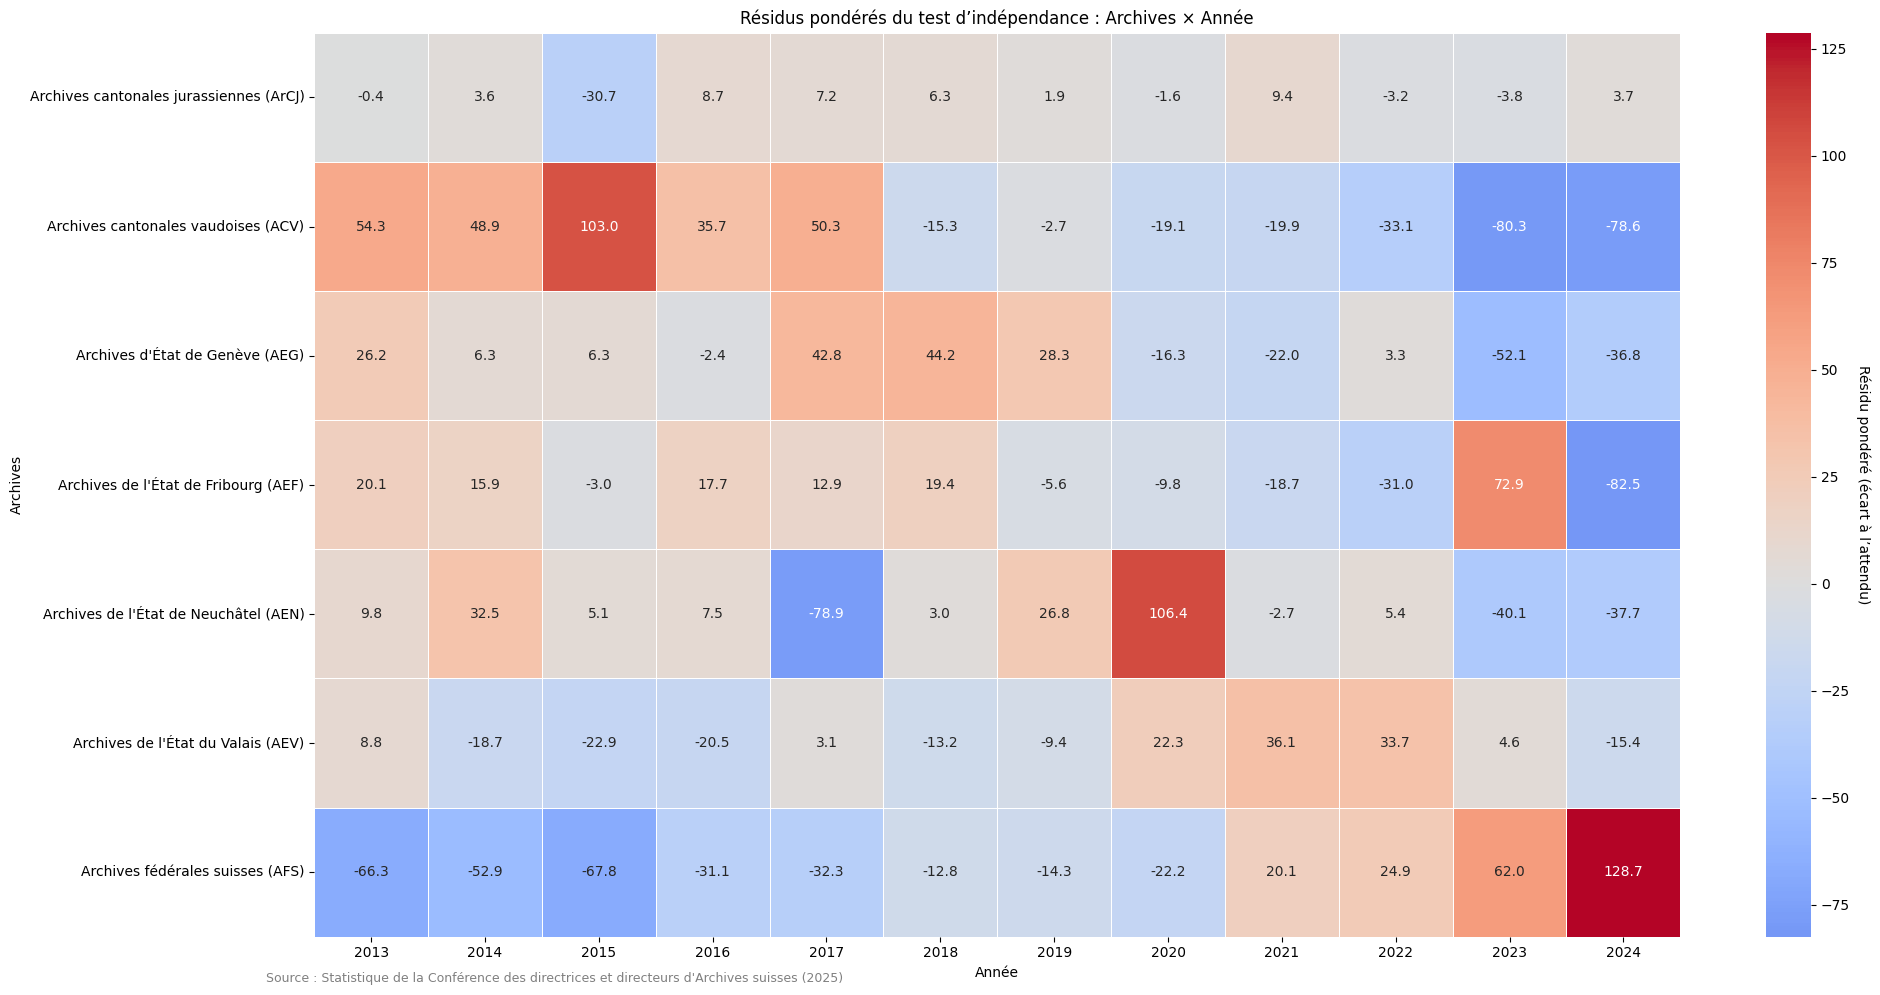

In [11]:
# 12. Visualisation heatmap des résidus (format décimal)
fig, ax = plt.subplots(figsize=(18, 10))


plt.title("Résidus pondérés du test d’indépendance : Archives × Année")
plt.xlabel("Année")
plt.ylabel("Archives")
plt.tight_layout()

heatmap = sns.heatmap(
    residus_T,
    annot=True,
    fmt=".1f",  # Format décimal standard
    cmap="coolwarm",
    linewidths=0.5,
    annot_kws={"fontsize": 10},
    ax=ax,
    center=0
)


# Légende de la barre de couleur
colorbar = heatmap.collections[0].colorbar
colorbar.set_label("Résidu pondéré (écart à l’attendu)", rotation=270, labelpad=15)

plt.figtext(
    0.01, 0.01,
    "Source : Statistique de la Conférence des directrices et directeurs d'Archives suisses (2025)",
    fontsize=9,
    ha='left',
    va='bottom',
    color='gray'
)

# 13. Sauvegarde possible
# plt.savefig("residus_ponderes_archives_annee.png")

plt.show()


In [20]:
# Créer une table de pivot (Année × Archives) avec les valeurs absolues
pivot_units = df_clean.pivot_table(index='Année', columns='Archives', values='Unités', aggfunc='sum')

# Trier les années
pivot_units = pivot_units.sort_index()

# Calcul des variations en pourcentage (différence année par année)
variation_pct = pivot_units.pct_change() * 100

# Arrondir à 1 décimale
variation_pct = variation_pct.round(1)


C:\Users\rroll\AppData\Local\Temp\ipykernel_61432\494995280.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  variation_pct = pivot_units.pct_change() * 100


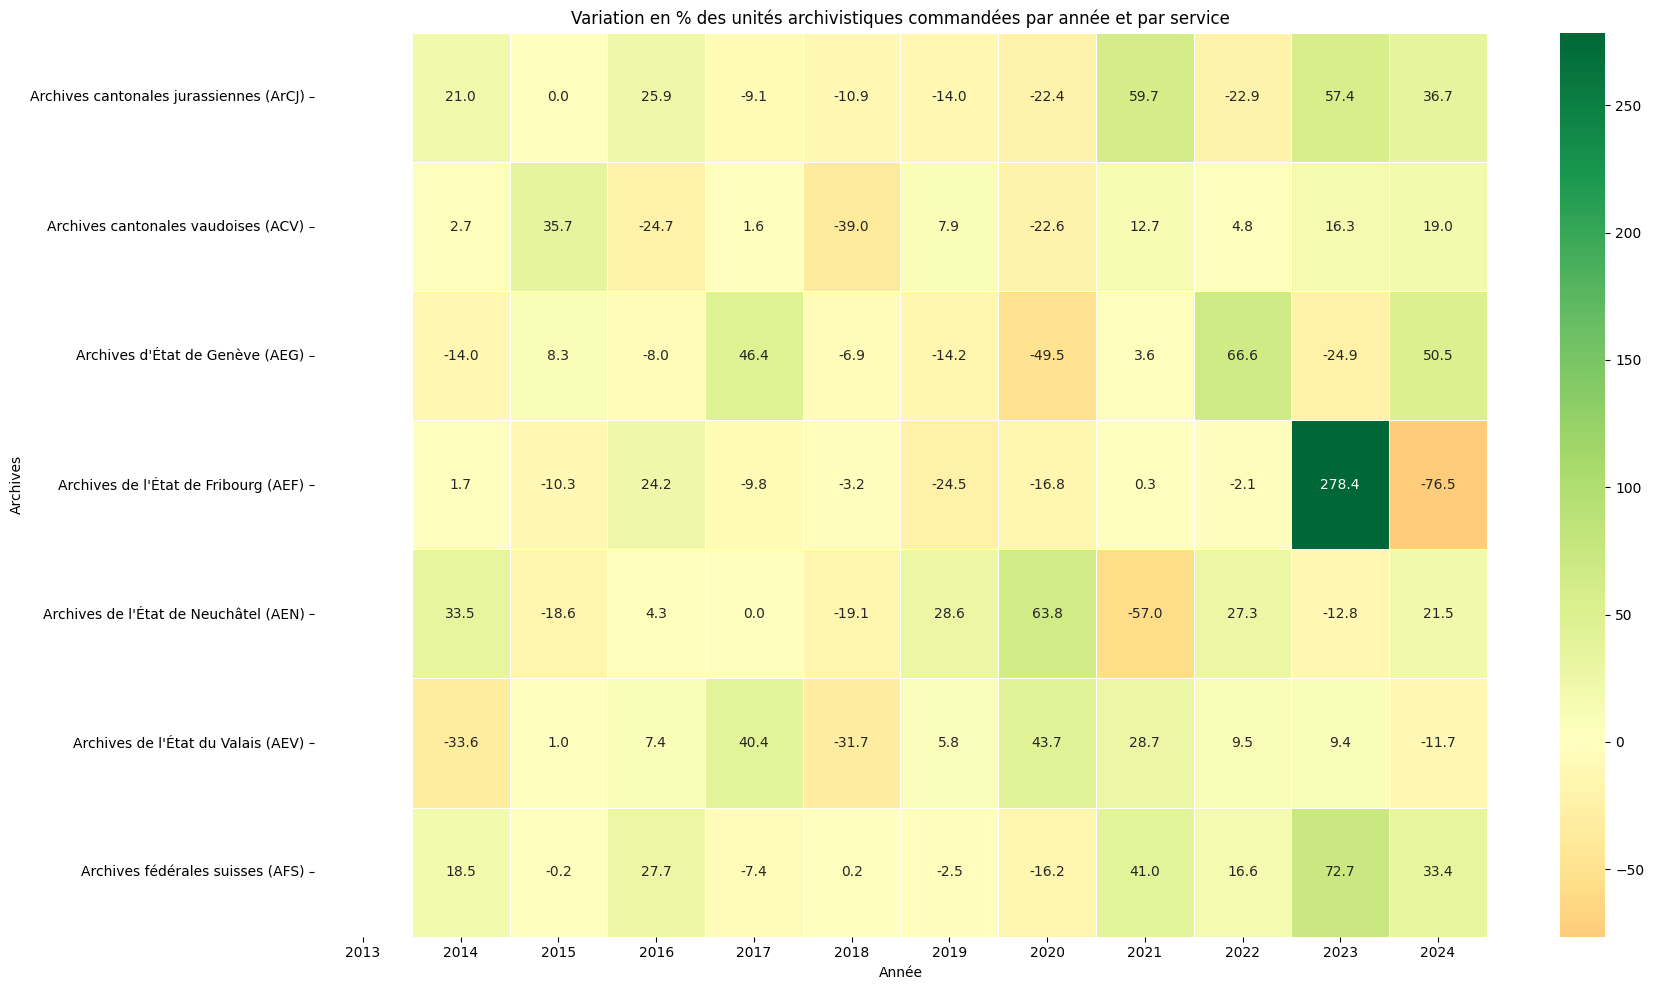

In [21]:
# Affichage d’une heatmap des variations %
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(variation_pct.transpose(), annot=True, fmt=".1f", cmap="RdYlGn", center=0,
            linewidths=0.5, annot_kws={"fontsize":10}, ax=ax)

plt.title("Variation en % des unités archivistiques commandées par année et par service")
plt.xlabel("Année")
plt.ylabel("Archives")
plt.tight_layout()

# Optionnel : enregistrer
# plt.savefig("variation_pourcentage_archives_annee.png")

plt.show()


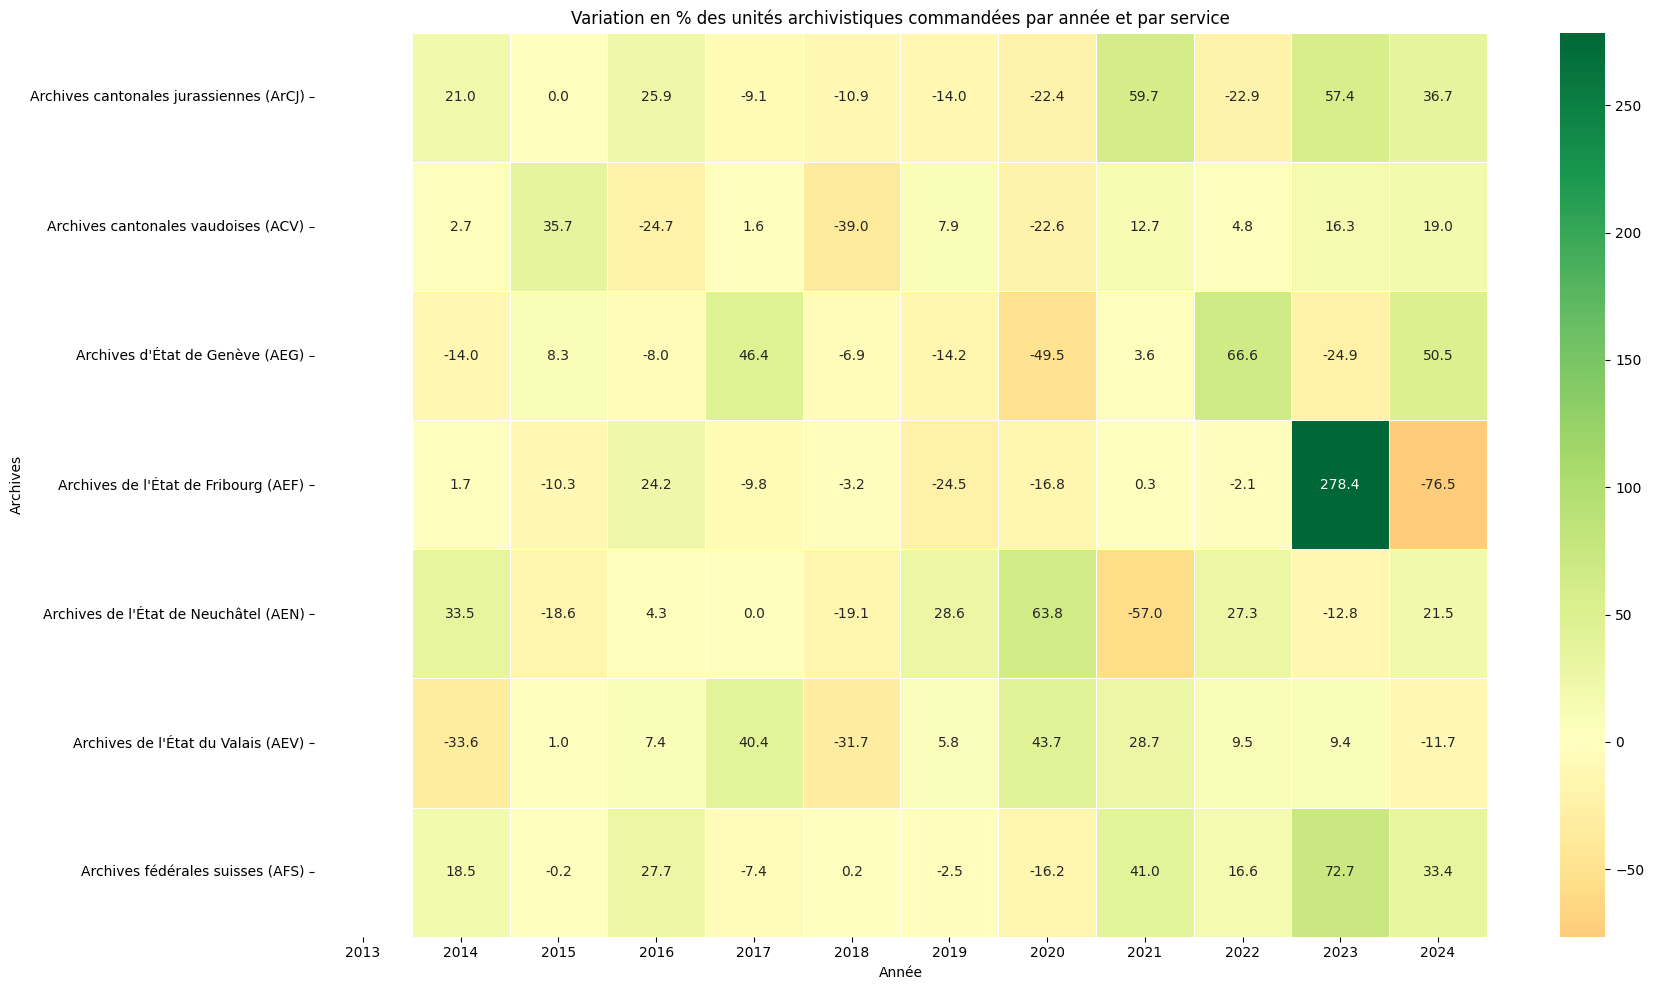

In [22]:
# Affichage d’une heatmap des variations %
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(variation_pct.transpose(), annot=True, fmt=".1f", cmap="RdYlGn", center=0,
            linewidths=0.5, annot_kws={"fontsize":10}, ax=ax)

plt.title("Variation en % des unités archivistiques commandées par année et par service")
plt.xlabel("Année")
plt.ylabel("Archives")
plt.tight_layout()

# Optionnel : enregistrer
# plt.savefig("variation_pourcentage_archives_annee.png")

plt.show()


C:\Users\rroll\AppData\Local\Temp\ipykernel_61432\2712899462.py:14: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  variation_pct = pivot_units.pct_change() * 100


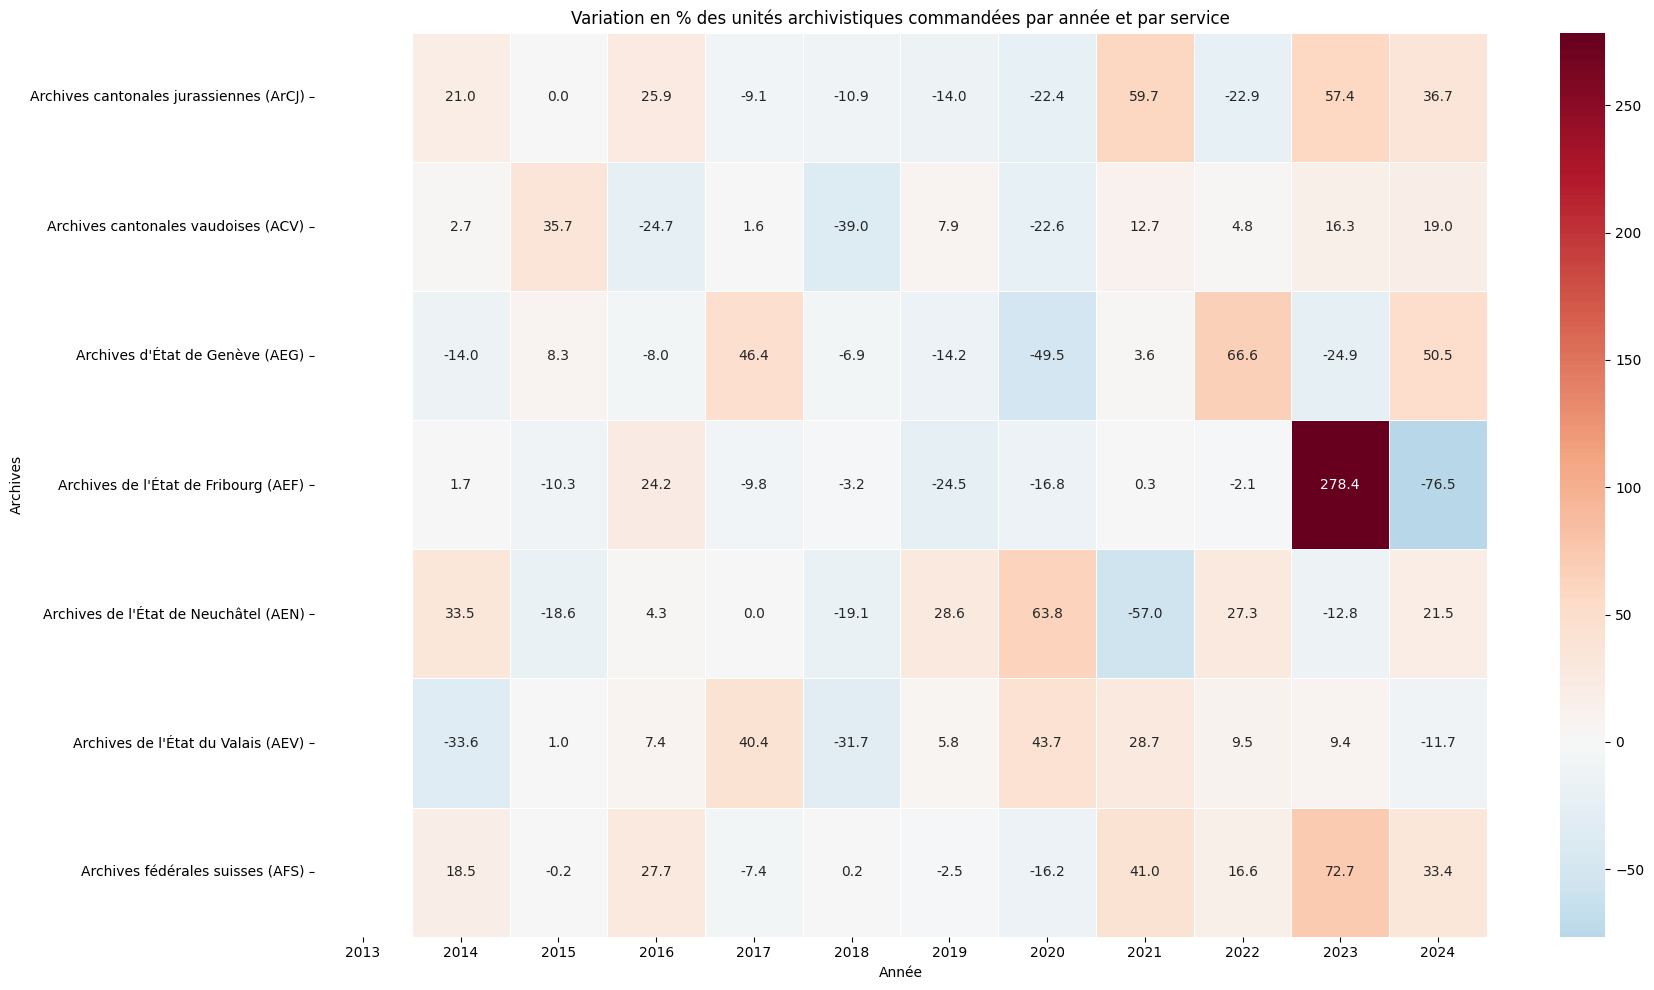

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Table de pivot : Année × Archives
pivot_units = df_clean.pivot_table(
    index='Année',
    columns='Archives',
    values='Unités',
    aggfunc='sum'
).sort_index()

# 2. Variation en %
variation_pct = pivot_units.pct_change() * 100
variation_pct = variation_pct.round(1)

# 3. Affichage de la heatmap avec palette personnalisée
fig, ax = plt.subplots(figsize=(18, 10))

sns.heatmap(
    variation_pct.transpose(),
    annot=True,
    fmt=".1f",
    cmap="RdBu_r",  # <- Inversée pour que rouge = hausse, bleu = baisse
    center=0,
    linewidths=0.5,
    annot_kws={"fontsize": 10},
    ax=ax
)

# 4. Mise en forme
plt.title("Variation en % des unités archivistiques commandées par année et par service")
plt.xlabel("Année")
plt.ylabel("Archives")
plt.tight_layout()

# 5. Sauvegarde optionnelle
# plt.savefig("variation_pourcentage_archives_annee_inversée.png")

plt.show()
